In [83]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import csv
import cv2
from cv2 import __version__
print __version__
import pandas as pd
import seaborn


3.3.0


In [2]:
def find_catchlights(image, threshold):
    #thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,thresh1 = cv2.threshold(gray,threshold,255,cv2.THRESH_BINARY)
    #we use erosion and dilation to remove noise
    morphKernel = np.ones((10, 10), np.uint8)
    morph = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, morphKernel)
    #find contours
    _, contours, hierarchy = cv2.findContours(morph.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #find catchlights using hierarchy
    largest = [1,2]
    catchlights = []
    for i in range(3,len(contours)):
        if (cv2.contourArea(contours[i]) > cv2.contourArea(contours[largest[0]])):
            largest[1] = largest[0]
            largest[0] = i
        elif (cv2.contourArea(contours[largest[0]]) > cv2.contourArea(contours[i]) > cv2.contourArea(contours[largest[1]])):
            largest[1] = i
    for i in range(0,len(contours)):
        if (hierarchy[0][i][3] == largest[0])or(hierarchy[0][i][3] == largest[1]):
            catchlights.append(contours[i])
    pupils = [contours[largest[0]],contours[largest[1]]]
    return catchlights, pupils


In [3]:
def get_brightness(image,contours):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = np.zeros(gray.shape,np.uint8)
    cv2.drawContours(mask,contours,-1,255,-1)
    pixelpoints = np.transpose(np.nonzero(mask))
    return cv2.mean(gray,mask = mask)[0],pixelpoints.size

(70.03737373737374, 3960)


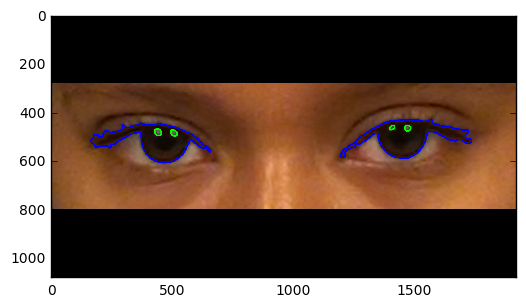

In [4]:
frame = cv2.imread('SampleFrames/frame15.jpg', cv2.IMREAD_COLOR)
catchlights,pupils = find_catchlights(frame, 45)
print get_brightness(frame,catchlights)

#draw contours
cv2.drawContours(frame, catchlights, -1, (0, 255, 0), 5)
cv2.drawContours(frame, pupils, -1, (255, 0, 0), 5)

frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()

In [14]:
video_name = "2012-07-16-13.25.47_1"

vidcap = cv2.VideoCapture('videos/' + video_name + ".mov")
print vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
with open(video_name + '.csv', 'wb') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(["frame","brightness","size","catchlights","blink"])
    for i in range(int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))):
        success,frame = vidcap.read()
        if success == False: break
        catchlights,_ = find_catchlights(frame,45)
        #check for blinking (simple method)
        bright,size = get_brightness(frame,catchlights)
        blink = 0
        if (len(catchlights) <= 2) or (len(catchlights) >= 6):
            blink = 1
        filewriter.writerow([i,bright,size,len(catchlights),blink])
        
    

901.0


In [15]:
Data = pd.read_csv(video_name + ".csv", sep=',', decimal='.', header=0)
Data.head()

,frame,brightness,size,catchlights,blink
0,0,77.367223,5272,4,0
1,1,76.788528,5230,4,0
2,2,76.983174,5230,4,0
3,3,77.244344,5304,4,0
4,4,73.581094,6326,5,0


<IPython.core.display.Javascript object>


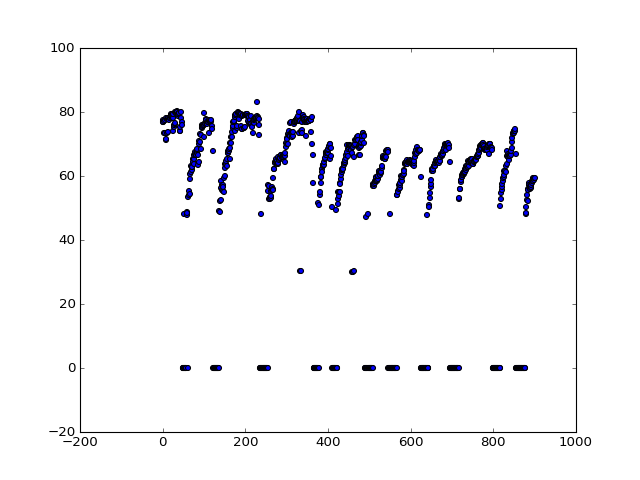

In [78]:
plt.scatter(Data["frame"], Data["brightness"])
plt.show()

<IPython.core.display.Javascript object>


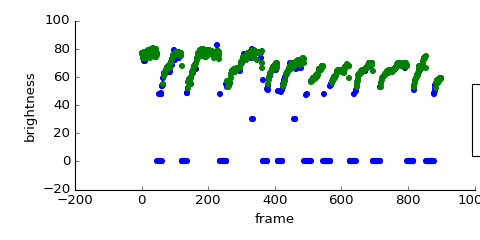

In [90]:
fg = seaborn.FacetGrid(data= Data, hue='blink', hue_order= [1,0], aspect = 2)
fg.map(plt.scatter, 'frame', 'brightness').add_legend()

<IPython.core.display.Javascript object>


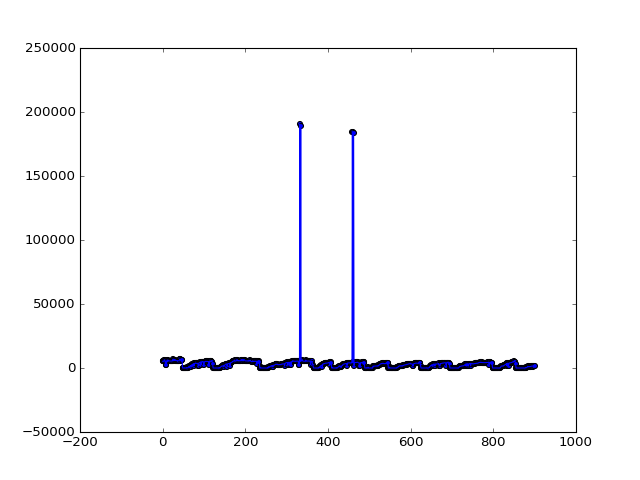

In [64]:
plt.plot(Data["frame"], Data["size"])
plt.scatter(Data["frame"], Data["size"])
plt.show()

Now we eliminate any row in which we think binking happens

<IPython.core.display.Javascript object>


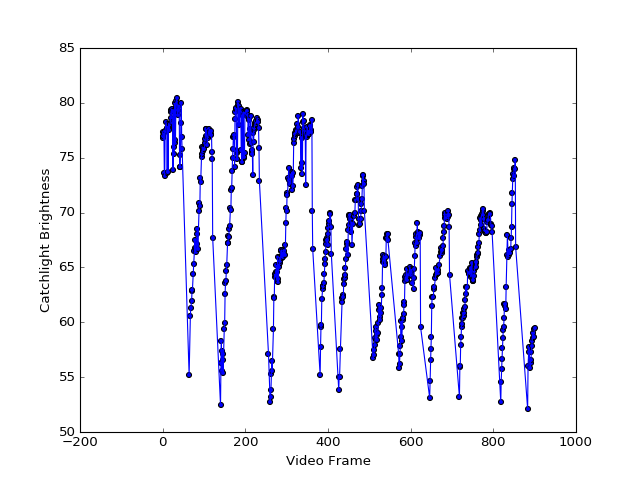

In [68]:
no_blink_data = Data[Data.blink != 1]
plt.plot(no_blink_data["frame"], no_blink_data["brightness"])
plt.scatter(no_blink_data["frame"], no_blink_data["brightness"])
plt.xlabel("Video Frame")
plt.ylabel("Catchlight Brightness")
plt.show()

<IPython.core.display.Javascript object>


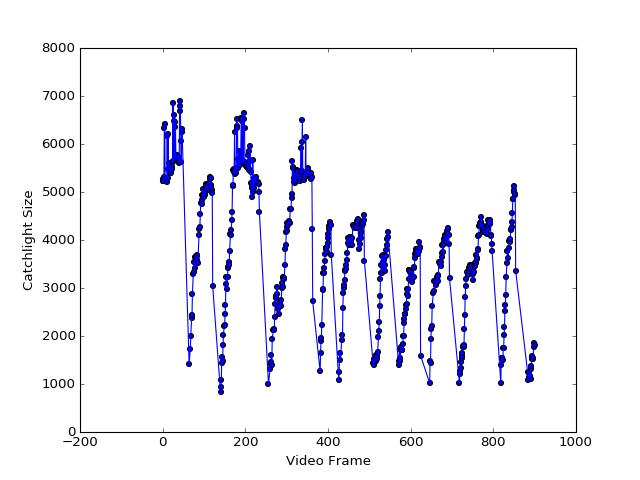

In [54]:
plt.scatter(no_blink_data["frame"], no_blink_data["size"])
plt.plot(no_blink_data["frame"], no_blink_data["size"])
plt.xlabel("Video Frame")
plt.ylabel("Catchlight Size")
plt.show()

<IPython.core.display.Javascript object>


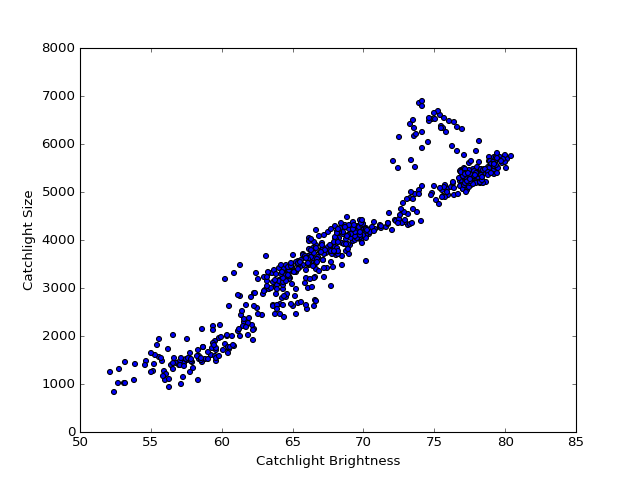

In [36]:
plt.scatter(no_blink_data["brightness"], no_blink_data["size"])
plt.xlabel("Catchlight Brightness")
plt.ylabel("Catchlight Size")
plt.show()

1


<IPython.core.display.Javascript object>


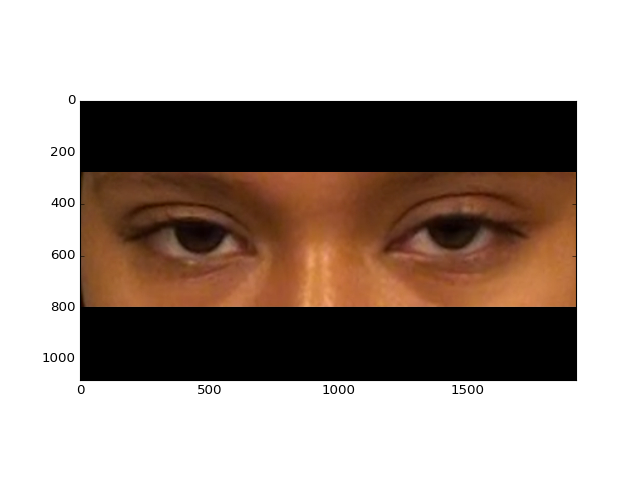

In [77]:
vidcap = cv2.VideoCapture('videos/' + video_name + ".mov")
vidcap.set(1, 130) 
print Data["blink"][130]
ret, frame = vidcap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.show()